# Restaurant Revenue Prediction

## Importing libraries

In [34]:
import pandas as pd
import numpy as np
import optuna as op
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import seaborn as sns
import datetime

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reading and first look to the dataset

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sampleSubmission.csv')

In [5]:
train

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,06/25/2008,Trabzon,Other,FC,2,3.0,3.0,5.0,4,...,3.0,0,0,0,0,0,0,0,0,5787594.0
133,133,10/12/2006,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,9262754.0
134,134,07/08/2006,Kayseri,Other,FC,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,2544857.0
135,135,10/29/2010,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,7217634.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          137 non-null    int64  
 1   Open Date   137 non-null    object 
 2   City        137 non-null    object 
 3   City Group  137 non-null    object 
 4   Type        137 non-null    object 
 5   P1          137 non-null    int64  
 6   P2          137 non-null    float64
 7   P3          137 non-null    float64
 8   P4          137 non-null    float64
 9   P5          137 non-null    int64  
 10  P6          137 non-null    int64  
 11  P7          137 non-null    int64  
 12  P8          137 non-null    int64  
 13  P9          137 non-null    int64  
 14  P10         137 non-null    int64  
 15  P11         137 non-null    int64  
 16  P12         137 non-null    int64  
 17  P13         137 non-null    float64
 18  P14         137 non-null    int64  
 19  P15         137 non-null    i

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          100000 non-null  int64  
 1   Open Date   100000 non-null  object 
 2   City        100000 non-null  object 
 3   City Group  100000 non-null  object 
 4   Type        100000 non-null  object 
 5   P1          100000 non-null  int64  
 6   P2          100000 non-null  float64
 7   P3          100000 non-null  float64
 8   P4          100000 non-null  float64
 9   P5          100000 non-null  int64  
 10  P6          100000 non-null  int64  
 11  P7          100000 non-null  int64  
 12  P8          100000 non-null  int64  
 13  P9          100000 non-null  int64  
 14  P10         100000 non-null  int64  
 15  P11         100000 non-null  int64  
 16  P12         100000 non-null  int64  
 17  P13         100000 non-null  float64
 18  P14         100000 non-null  int64  
 19  P15

The test set is way bigger than the train set.

Also, it seems we have several cities...

In [7]:
train['City'].value_counts()

City
İstanbul          50
Ankara            19
İzmir              9
Bursa              5
Samsun             5
Sakarya            4
Antalya            4
Kayseri            3
Eskişehir          3
Adana              3
Diyarbakır         3
Tekirdağ           3
Muğla              2
Trabzon            2
Aydın              2
Konya              2
Karabük            1
Isparta            1
Bolu               1
Kütahya            1
Amasya             1
Balıkesir          1
Denizli            1
Kocaeli            1
Kırklareli         1
Edirne             1
Uşak               1
Kastamonu          1
Tokat              1
Şanlıurfa          1
Elazığ             1
Gaziantep          1
Afyonkarahisar     1
Osmaniye           1
Name: count, dtype: int64

We can also see some statistics of the train dataset.

In [47]:
train.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


Let's check if we have null values.

In [33]:
train.isna().sum()

Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

In [34]:
test.isna().sum()

Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
dtype: int64

## Data Preprocessing and Feature Engineering

First, we need to let pandas know that we are actually working with dates.

In [7]:
train['Open Date'] = pd.to_datetime(train['Open Date'])
test['Open Date'] = pd.to_datetime(test['Open Date'])

Now, since the we are going to predict the revenue of a restaurant, will be a good idea to let our model know how much time a restaurant has been open.

In [8]:
train['OpenDays']=""
test['OpenDays']=""

dateLastTrain = pd.DataFrame({'Date':np.repeat(['01/01/2015'],[len(train)]) })
dateLastTrain['Date'] = pd.to_datetime(dateLastTrain['Date'], format='%m/%d/%Y')  
dateLastTest = pd.DataFrame({'Date':np.repeat(['01/01/2015'],[len(test)]) })
dateLastTest['Date'] = pd.to_datetime(dateLastTest['Date'], format='%m/%d/%Y')  

train['OpenDays'] = dateLastTrain['Date'] - train['Open Date']
test['OpenDays'] = dateLastTest['Date'] - test['Open Date']

train['OpenDays'] = train['OpenDays'].astype(str)
test['OpenDays'] =test['OpenDays'].astype(str)

train['OpenDays'] = train['OpenDays'].str.extract('(\d+)').astype(int)
test['OpenDays'] = test['OpenDays'].str.extract('(\d+)').astype(int)

In [221]:
train['OpenDays']

0      5647
1      2513
2       663
3      1064
4      2063
       ... 
132    2381
133    3003
134    3099
135    1525
136    1948
Name: OpenDays, Length: 137, dtype: int32

In adittion to the feature above, we also are gonna add other date related features, as well as making sure the types of each feature are actually what we think they are.

In [9]:
def trans_df_dates(df, col):
    #df["weekday_sv"] = df[col].dt.strftime("%a").astype("category")
    df["weekday_num"] = df[col].dt.strftime("%w").astype("int")
    df["day_of_month"] = df[col].dt.strftime("%d").astype("int")
    #df["month_name_sv"] = df[col].dt.strftime("%b").astype("category")
    df["month_num"] = df[col].dt.strftime("%m").astype("int")
    df["year_fv"] = df[col].dt.strftime("%Y").astype("int")
    df["day_number_year"] = df[col].dt.strftime("%j").astype("int")
    df["week_number_year"] = df[col].dt.strftime("%W").astype("int")
    df["City Group"] = df["City Group"].astype("category")
    df["City"] = df["City"].astype("category")
    df["Type"] = df["Type"].astype("category")
    df["year_sin"] = np.sin(2 * np.pi * df["year_fv"]/18)
    df["year_cos"] = np.cos(2 * np.pi * df["year_fv"]/18)
    df["month_sin"] = np.sin(2 * np.pi * df["month_num"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month_num"] / 12.0)
    df['day_sin'] = np.sin(2 * np.pi + df['day_of_month']  / 365.0)
    df['day_cos'] = np.cos(2 * np.pi + df['day_of_month'] / 365.0)
    df['Group'] = (df['year_fv'] - 1996) * 48 + df['month_num'] * 4 + df['day_of_month'] // 18
    return df

train_trans = train.copy()
test_trans = test.copy()

train_trans = trans_df_dates(train, 'Open Date')
test_trans = trans_df_dates(test, 'Open Date')

train_trans = train_trans.drop(columns=['Open Date','Id'])
test_trans = test_trans.drop(columns=['Open Date','Id'])

train_trans


,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,year_fv,day_number_year,week_number_year,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,Group
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,...,1999,198,28,0.342020,0.939693,-5.000000e-01,-8.660254e-01,0.046559,0.998916,172
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,...,2008,45,6,-0.342020,-0.939693,8.660254e-01,5.000000e-01,0.038347,0.999264,584
2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,...,2013,68,9,-0.866025,0.500000,1.000000e+00,6.123234e-17,0.024655,0.999696,828
3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,...,2012,33,5,-0.984808,0.173648,8.660254e-01,5.000000e-01,0.005479,0.999985,776
4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,...,2009,129,18,-0.642788,-0.766044,5.000000e-01,-8.660254e-01,0.024655,0.999696,644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Trabzon,Other,FC,2,3.0,3.0,5.0,4,2,4,...,2008,177,25,-0.342020,-0.939693,1.224647e-16,-1.000000e+00,0.068440,0.997655,601
133,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,3,5,...,2006,285,41,0.342020,-0.939693,-8.660254e-01,5.000000e-01,0.032871,0.999460,520
134,Kayseri,Other,FC,3,4.0,4.0,4.0,2,3,5,...,2006,189,27,0.342020,-0.939693,-5.000000e-01,-8.660254e-01,0.021916,0.999760,508
135,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,2,5,...,2010,302,43,-0.866025,-0.500000,-8.660254e-01,5.000000e-01,0.079368,0.996845,713


Now, let's focus our attention to the categorical features. 

In [50]:
categorical_columns = train_trans.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['City', 'City Group', 'Type'], dtype='object')


In [51]:
for category in categorical_columns:
    print(train[category].unique())

['İstanbul', 'Ankara', 'Diyarbakır', 'Tokat', 'Gaziantep', ..., 'Kütahya', 'Bolu', 'Trabzon', 'Isparta', 'Osmaniye']
Length: 34
Categories (34, object): ['Adana', 'Afyonkarahisar', 'Amasya', 'Ankara', ..., 'Uşak', 'İstanbul', 'İzmir', 'Şanlıurfa']
['Big Cities', 'Other']
Categories (2, object): ['Big Cities', 'Other']
['IL', 'FC', 'DT']
Categories (3, object): ['DT', 'FC', 'IL']


As we can see, the City feature has a lot of cities, so might be better to use, for example, an encoder like TargetEncoder, instead of OneHot (otherwise dimensionality could be an issue). However, we have a problem. As one can read on Kaggle's page, there are cities on the test set that are not on the train (there's the explanaition of this on the mentioned webpage), so we might need to take another approach. For now, let's see if we can see some correlation on the realm of the numerical features.

In [11]:
numerical_columns = train_trans.select_dtypes(include=['float64', 'int64']).columns
print(numerical_columns)

Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue', 'year_sin',
       'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'],
      dtype='object')


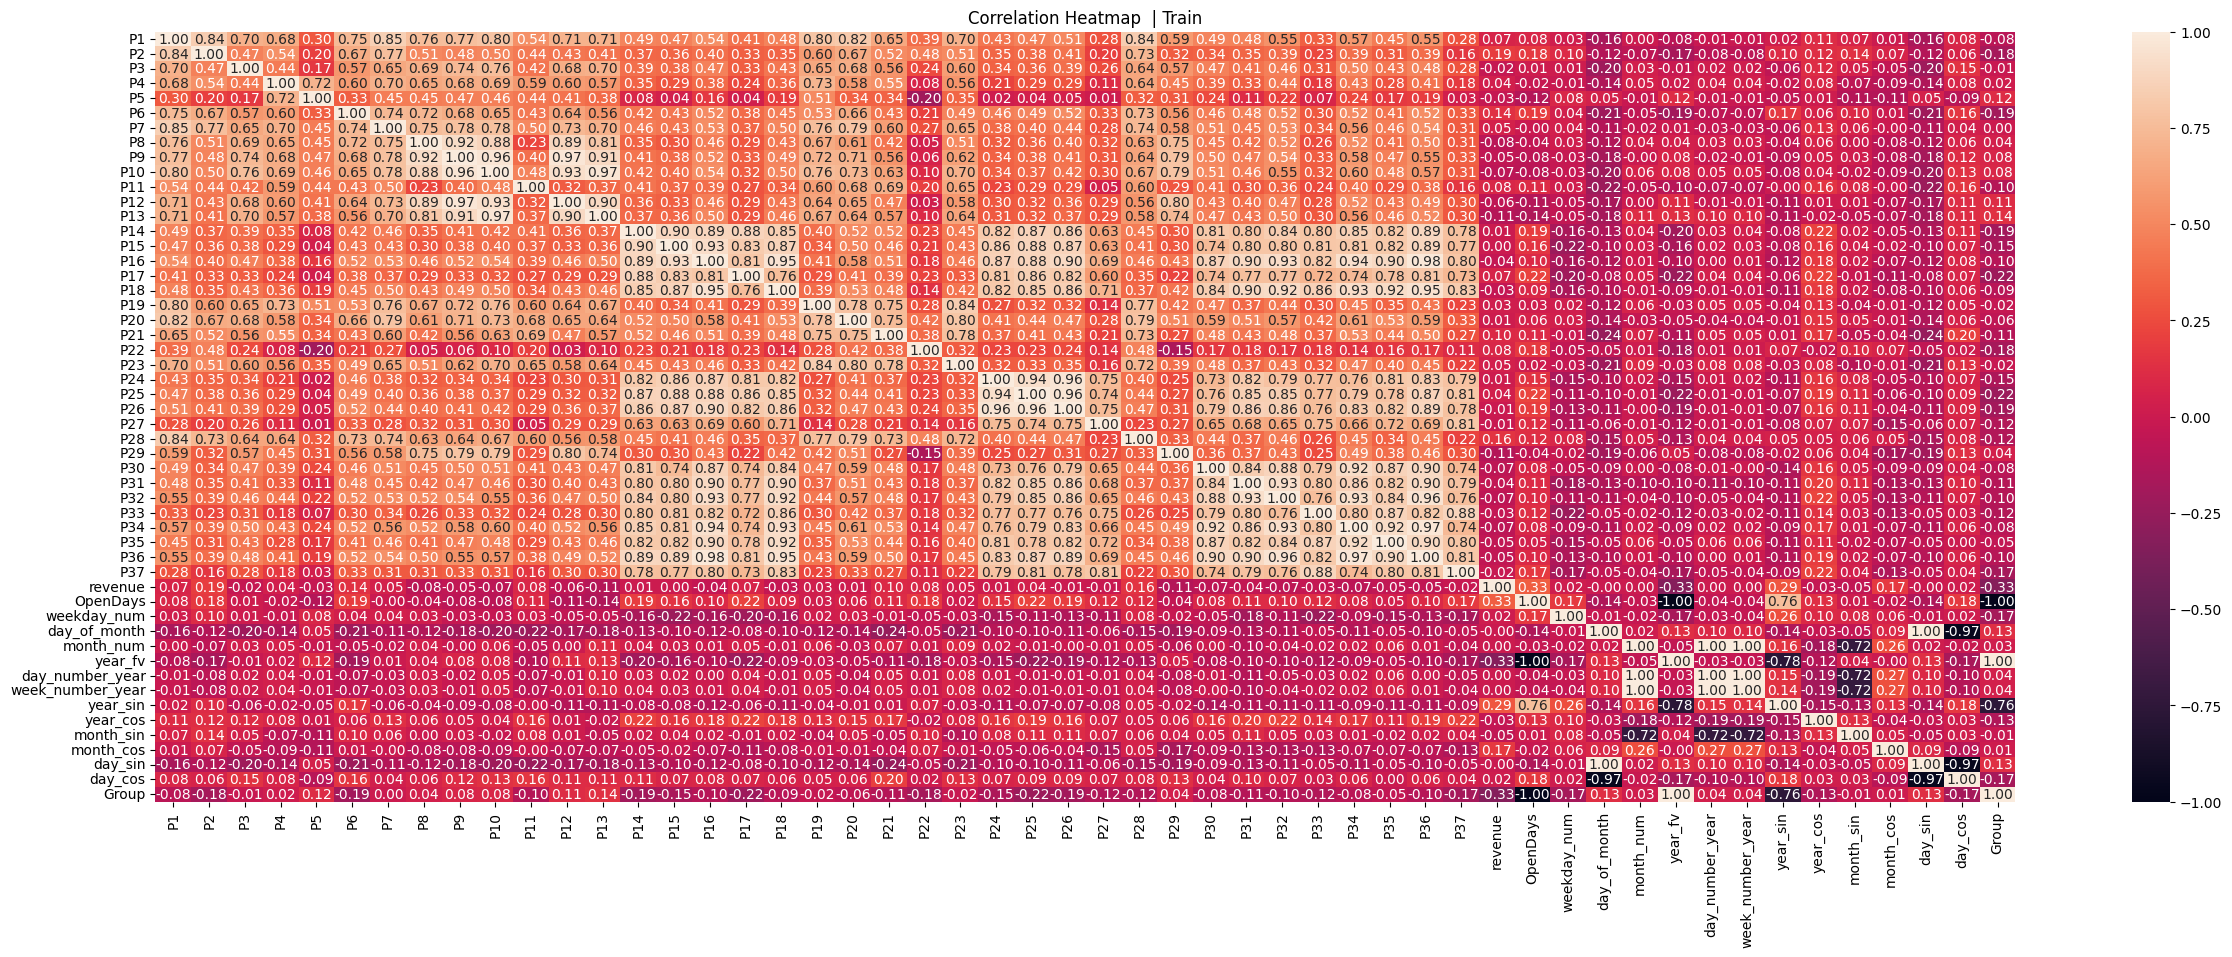

In [13]:
num_vars_train = train_trans.select_dtypes("number").columns.to_list()
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(
    train_trans[num_vars_train].corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    #cmap="PuBuGn",
    #annot_kws={"fontsize": 10},
    cbar_kws={"shrink": 1},
    ax = ax
)

plt.title("Correlation Heatmap  | Train")
plt.show()

As we can see, there's an interesting correlation between the created OpenDays feature and the target.

K, coming back to the categorical columns, let's see in fact the mentioned difference of unique categories over the training and test set.

In [67]:
for category in categorical_columns:
    print(train_trans[category].unique())
    print(test_trans[category].unique())

['İstanbul', 'Ankara', 'Diyarbakır', 'Tokat', 'Gaziantep', ..., 'Kütahya', 'Bolu', 'Trabzon', 'Isparta', 'Osmaniye']
Length: 34
Categories (34, object): ['Adana', 'Afyonkarahisar', 'Amasya', 'Ankara', ..., 'Uşak', 'İstanbul', 'İzmir', 'Şanlıurfa']
['Niğde', 'Konya', 'Ankara', 'Kocaeli', 'Afyonkarahisar', ..., 'Uşak', 'Kütahya', 'Siirt', 'Çankırı', 'Isparta']
Length: 57
Categories (57, object): ['Adana', 'Afyonkarahisar', 'Aksaray', 'Ankara', ..., 'Çorum', 'İstanbul', 'İzmir', 'Şanlıurfa']
['Big Cities', 'Other']
Categories (2, object): ['Big Cities', 'Other']
['Other', 'Big Cities']
Categories (2, object): ['Big Cities', 'Other']
['IL', 'FC', 'DT']
Categories (3, object): ['DT', 'FC', 'IL']
['FC', 'IL', 'DT', 'MB']
Categories (4, object): ['DT', 'FC', 'IL', 'MB']


There's also one more category on the Type feature. However, the discrepancy is not that big comparing the the City one...

In order to encode this columns, let's start by concatenating both datasets.

In [14]:
train_trans_lenght = train_trans.shape[0]
test_trans_lenght = test_trans.shape[0]

combined = pd.concat((train_trans, test_trans), ignore_index=True)
combined

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,year_fv,day_number_year,week_number_year,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,Group
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,...,1999,198,28,0.342020,0.939693,-5.000000e-01,-8.660254e-01,0.046559,0.998916,172
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,...,2008,45,6,-0.342020,-0.939693,8.660254e-01,5.000000e-01,0.038347,0.999264,584
2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,...,2013,68,9,-0.866025,0.500000,1.000000e+00,6.123234e-17,0.024655,0.999696,828
3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,...,2012,33,5,-0.984808,0.173648,8.660254e-01,5.000000e-01,0.005479,0.999985,776
4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,...,2009,129,18,-0.642788,-0.766044,5.000000e-01,-8.660254e-01,0.024655,0.999696,644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100132,Antalya,Other,FC,5,5.0,4.0,4.0,2,2,5,...,2000,5,1,0.642788,0.766044,5.000000e-01,8.660254e-01,0.013698,0.999906,196
100133,Niğde,Other,IL,1,2.0,4.0,3.0,1,1,1,...,2011,199,29,-0.984808,-0.173648,-5.000000e-01,-8.660254e-01,0.049295,0.998784,749
100134,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,2,5,...,2012,364,52,-0.984808,0.173648,-2.449294e-16,1.000000e+00,0.079368,0.996845,817
100135,İstanbul,Big Cities,FC,12,7.5,6.0,6.0,4,4,10,...,2013,285,40,-0.866025,0.500000,-8.660254e-01,5.000000e-01,0.032871,0.999460,856


To encode the City Column, let's use Kmeans and train them over the P variables, which provide demographic, real estate and commercial data about the cities. Ofc, might be interesting to add the city group but this is not a numeric column at first, so for simplicity, we using just the P variables. To encode the rest of categorical columns, we will use LabelEncoder.

In [27]:
pvars = [f'P{x}' for x in range(1,38)]

k_train = train_trans.loc[:, pvars]
    
#Let's try Kme 
kmeans = KMeans(n_clusters=20)
kmeans.fit(k_train)
    
# Get the cluster centers and classify city of each data instance to one of the centers
combined['City Cluster'] = kmeans.predict(combined.loc[:, pvars])
combined = combined.drop(columns='City')    

encoder = LabelEncoder()

combined['City Group'] = encoder.fit_transform(combined["City Group"])
combined['Type'] = encoder.fit_transform(combined['Type'])

train_trans_processed = combined[:train_trans_lenght]
test_trans_processed = combined[train_trans_lenght:]

test_trans_processed = test_trans_processed.drop(columns='revenue')

In [28]:
train_trans_processed

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,day_number_year,week_number_year,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,Group,City Cluster
0,0,2,4,5.0,4.0,4.0,2,2,5,4,...,198,28,0.342020,0.939693,-5.000000e-01,-8.660254e-01,0.046559,0.998916,172,13
1,0,1,4,5.0,4.0,4.0,1,2,5,5,...,45,6,-0.342020,-0.939693,8.660254e-01,5.000000e-01,0.038347,0.999264,584,7
2,1,2,2,4.0,2.0,5.0,2,3,5,5,...,68,9,-0.866025,0.500000,1.000000e+00,6.123234e-17,0.024655,0.999696,828,7
3,1,2,6,4.5,6.0,6.0,4,4,10,8,...,33,5,-0.984808,0.173648,8.660254e-01,5.000000e-01,0.005479,0.999985,776,10
4,1,2,3,4.0,3.0,4.0,2,2,5,5,...,129,18,-0.642788,-0.766044,5.000000e-01,-8.660254e-01,0.024655,0.999696,644,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,1,1,2,3.0,3.0,5.0,4,2,4,4,...,177,25,-0.342020,-0.939693,1.224647e-16,-1.000000e+00,0.068440,0.997655,601,2
133,0,1,4,5.0,4.0,4.0,2,3,5,4,...,285,41,0.342020,-0.939693,-8.660254e-01,5.000000e-01,0.032871,0.999460,520,2
134,1,1,3,4.0,4.0,4.0,2,3,5,5,...,189,27,0.342020,-0.939693,-5.000000e-01,-8.660254e-01,0.021916,0.999760,508,7
135,0,1,4,5.0,4.0,5.0,2,2,5,5,...,302,43,-0.866025,-0.500000,-8.660254e-01,5.000000e-01,0.079368,0.996845,713,7


In [29]:
test_trans_processed

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,day_number_year,week_number_year,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,Group,City Cluster
137,1,1,1,4.0,4.0,4.0,1,2,5,4,...,22,3,-0.984808,-0.173648,5.000000e-01,8.660254e-01,0.060237,0.998184,725,2
138,1,2,3,4.0,4.0,4.0,2,2,5,3,...,77,11,-0.984808,-0.173648,1.000000e+00,6.123234e-17,0.049295,0.998784,733,2
139,0,1,3,4.0,4.0,4.0,2,2,5,4,...,303,43,-0.866025,0.500000,-8.660254e-01,5.000000e-01,0.082099,0.996624,857,8
140,1,2,2,4.0,4.0,4.0,2,3,5,4,...,126,18,-0.866025,0.500000,5.000000e-01,-8.660254e-01,0.016438,0.999865,836,2
141,1,1,2,4.0,4.0,4.0,1,2,5,4,...,212,30,-0.866025,0.500000,-5.000000e-01,-8.660254e-01,0.084829,0.996395,845,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100132,1,1,5,5.0,4.0,4.0,2,2,5,5,...,5,1,0.642788,0.766044,5.000000e-01,8.660254e-01,0.013698,0.999906,196,2
100133,1,2,1,2.0,4.0,3.0,1,1,1,5,...,199,29,-0.984808,-0.173648,-5.000000e-01,-8.660254e-01,0.049295,0.998784,749,19
100134,0,2,4,5.0,4.0,4.0,1,2,5,3,...,364,52,-0.984808,0.173648,-2.449294e-16,1.000000e+00,0.079368,0.996845,817,16
100135,0,1,12,7.5,6.0,6.0,4,4,10,10,...,285,40,-0.866025,0.500000,-8.660254e-01,5.000000e-01,0.032871,0.999460,856,4


Let's now divide our data and scale it. The scaling process is because the features (as well as the target) have a wide range, and we are gonna use a linear model, not only a tree based model.

In [30]:
print(train_trans_processed['revenue'].min())
print(train_trans_processed['revenue'].max())

1149870.0
19696939.0


In [43]:
X= train_trans_processed.copy()
y = X.pop('revenue')

y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Initialize the scaler

#scaler1 = StandardScaler()
scaler2 = StandardScaler()
# Scale the target (y)
#y_train_s = scaler1.fit_transform(y_train.values.reshape(-1,1))
#y_test_s = scaler1.transform(y_test.values.reshape(-1,1))

# Scale the features (X)
X_train_s = scaler2.fit_transform(X_train)
X_test_s =scaler2.transform(X_test)
test_trans_processed_s = scaler2.transform(test_trans_processed)


#y_train_s = pd.Series(y_train_s.flatten(), index=y_train.index)  
#y_test_s = pd.Series(y_test_s.flatten(), index=y_test.index)

X_train_s = pd.DataFrame(X_train_s, columns=X_train.columns, index=X_train.index) 
X_test_s = pd.DataFrame(X_test_s, columns=X_test.columns, index=X_test.index)
test_trans_processed_s = pd.DataFrame(test_trans_processed_s, columns=test_trans_processed.columns, index=test_trans_processed.index )

## Model training

In [44]:
def objective(trial):
    # Set the parameters for LightGBM
    param = {
        "objective": "regression",
        "metric": "l2",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "verbose": -1,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train_s.iloc[train_idx], X_train_s.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train a Linear Regression model
        lin_reg = Ridge()
        lin_reg.fit(X_tr, y_tr)
        
        # Predict with Linear Regression and compute residuals
        y_tr_pred = lin_reg.predict(X_tr)
        y_val_pred = lin_reg.predict(X_val)
        
        residuals_tr = y_tr - y_tr_pred
        residuals_val = y_val - y_val_pred

        # Train LightGBM on the residuals
        train_data = lgb.Dataset(X_tr, label=residuals_tr)
        val_data = lgb.Dataset(X_val, label=residuals_val, reference=train_data)

        model = lgb.train(param, train_data, valid_sets=[val_data])

        # Predict residuals using LightGBM
        residuals_pred = model.predict(X_val)

        # Final prediction: linear model prediction + residual prediction
        y_final_pred = y_val_pred + residuals_pred

          # Ensure that both y_val and y_final_pred are 1D arrays (flatten if necessary)
        #y_val = y_val.values.flatten() if isinstance(y_val, pd.Series) else y_val
        #y_final_pred = y_final_pred.flatten()

        #print(y_val)
        #print(y_final_pred)
        # Calculate MSE for the current fold
        mse = np.sqrt(mean_squared_error(y_val, y_final_pred))
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Run Optuna
op.logging.set_verbosity(op.logging.INFO)
study = op.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Get best hyperparameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2025-02-24 15:34:51,267] A new study created in memory with name: no-name-c50d910a-148f-4814-961b-1bb9072dcaae
[I 2025-02-24 15:34:51,402] Trial 0 finished with value: 0.5560075211297036 and parameters: {'learning_rate': 0.01468916362087704, 'num_leaves': 89, 'max_depth': 6, 'min_data_in_leaf': 45, 'lambda_l1': 7.397789747312555e-06, 'lambda_l2': 0.00010503444276823853, 'feature_fraction': 0.7002667857514602}. Best is trial 0 with value: 0.5560075211297036.
[I 2025-02-24 15:34:51,612] Trial 1 finished with value: 0.5551789254020818 and parameters: {'learning_rate': 0.010554390212898803, 'num_leaves': 75, 'max_depth': 5, 'min_data_in_leaf': 38, 'lambda_l1': 1.0494373051701526e-08, 'lambda_l2': 1.089729790325912, 'feature_fraction': 0.6343973303631572}. Best is trial 1 with value: 0.5551789254020818.
[I 2025-02-24 15:34:51,845] Trial 2 finished with value: 0.5460360182843694 and parameters: {'learning_rate': 0.03279790992846085, 'num_leaves': 36, 'max_depth': 3, 'min_data_in_leaf': 17

Best parameters: {'learning_rate': 0.18745934047449875, 'num_leaves': 64, 'max_depth': 4, 'min_data_in_leaf': 27, 'lambda_l1': 9.858771128767027e-05, 'lambda_l2': 0.0009408515215292366, 'feature_fraction': 0.7867143907012205}


In [45]:
best_params

{'learning_rate': 0.18745934047449875,
 'num_leaves': 64,
 'max_depth': 4,
 'min_data_in_leaf': 27,
 'lambda_l1': 9.858771128767027e-05,
 'lambda_l2': 0.0009408515215292366,
 'feature_fraction': 0.7867143907012205}

In [46]:
best_param = {
        "objective": "regression",
        "metric": "l2",
        "boosting_type": "gbdt",
        'learning_rate': 0.18745934047449875,
 'num_leaves': 64,
 'max_depth': 4,
 'min_data_in_leaf': 27,
 'lambda_l1': 9.858771128767027e-05,
 'lambda_l2': 0.0009408515215292366,
 'feature_fraction': 0.7867143907012205}

Let's train now the final model and see how well it does.

In [47]:
# Train the final Linear Regression model
lin_reg_final = Ridge()
lin_reg_final.fit(X_train_s, y_train)

# Predict y_train using Linear Regression
y_train_pred = lin_reg_final.predict(X_train_s)

# Compute residuals
residuals_train = y_train - y_train_pred

# Train the final LightGBM model on residuals
train_data = lgb.Dataset(X_train_s, label=residuals_train)
lgb_final = lgb.train(best_params, train_data)

# Predict on test data
y_test_pred_lr = lin_reg_final.predict(X_test_s)  # Linear model prediction
y_test_pred_residuals = lgb_final.predict(X_test_s)  # Residual prediction

# Final predictions = Linear model prediction + Residual correction
y_test_final_pred = y_test_pred_lr + y_test_pred_residuals

np.sqrt(mean_squared_error(y_test, y_test_final_pred))

0.6512388413853167

Let's see which feature considered the model the most important.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

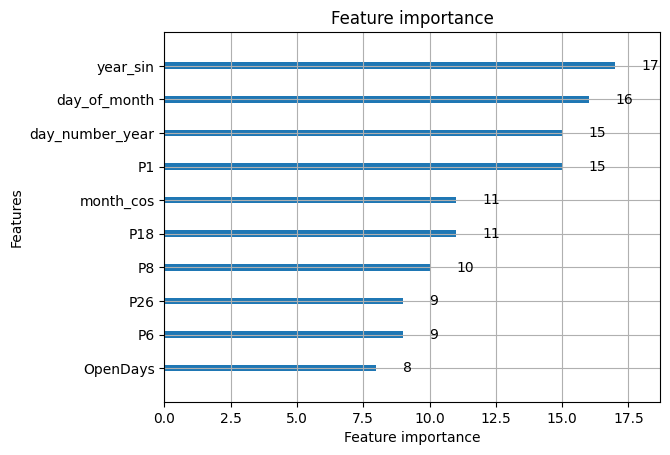

In [52]:
lgb.plot_importance(lgb_final, max_num_features=10)

## Finishing by predicting Kaggle's test set.

In [54]:
sample_sub["Prediction"] = np.exp(lin_reg_final.predict(test_trans_processed_s) + lgb_final.predict(test_trans_processed_s) )

sample_sub.to_csv("submission.csv", index=False)
sample_sub

,Id,Prediction
0,0,5.464025e+06
1,1,2.407770e+06
2,2,2.915141e+06
3,3,1.691803e+06
4,4,3.836732e+06
...,...,...
99995,99995,3.197708e+06
99996,99996,2.708999e+06
99997,99997,8.453901e+06
99998,99998,5.345962e+06


In [55]:
sample_sub.describe()

,Id,Prediction
count,100000.000000,1.000000e+05
mean,49999.500000,5.540193e+06
std,28867.657797,1.345406e+07
min,0.000000,8.322164e+03
25%,24999.750000,2.321828e+06
50%,49999.500000,3.556637e+06
75%,74999.250000,5.587537e+06
max,99999.000000,1.117035e+09


## Other ideas to implement.

In adittion to training other models or combining some of them, we can also try encoding the whole combined dataset, by doing Label or OneHot. However, the presence of additional categories on the test is something to considerer. Trying different number of clusters could be another option, withouth changing the encoding.

Thanks for reading. Fernan Zl